## Import library yang dibutuhkan

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
import keras_tuner as kt

## Memuat dataset dan menggabungkan training dan testing jadi satu terlebih dahulu

In [2]:
# Memuat dataset fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Menggabungkan data train dan test
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

## Nama tiap kelas

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Nomor 1. A

## Sample 5 gambar per kelas

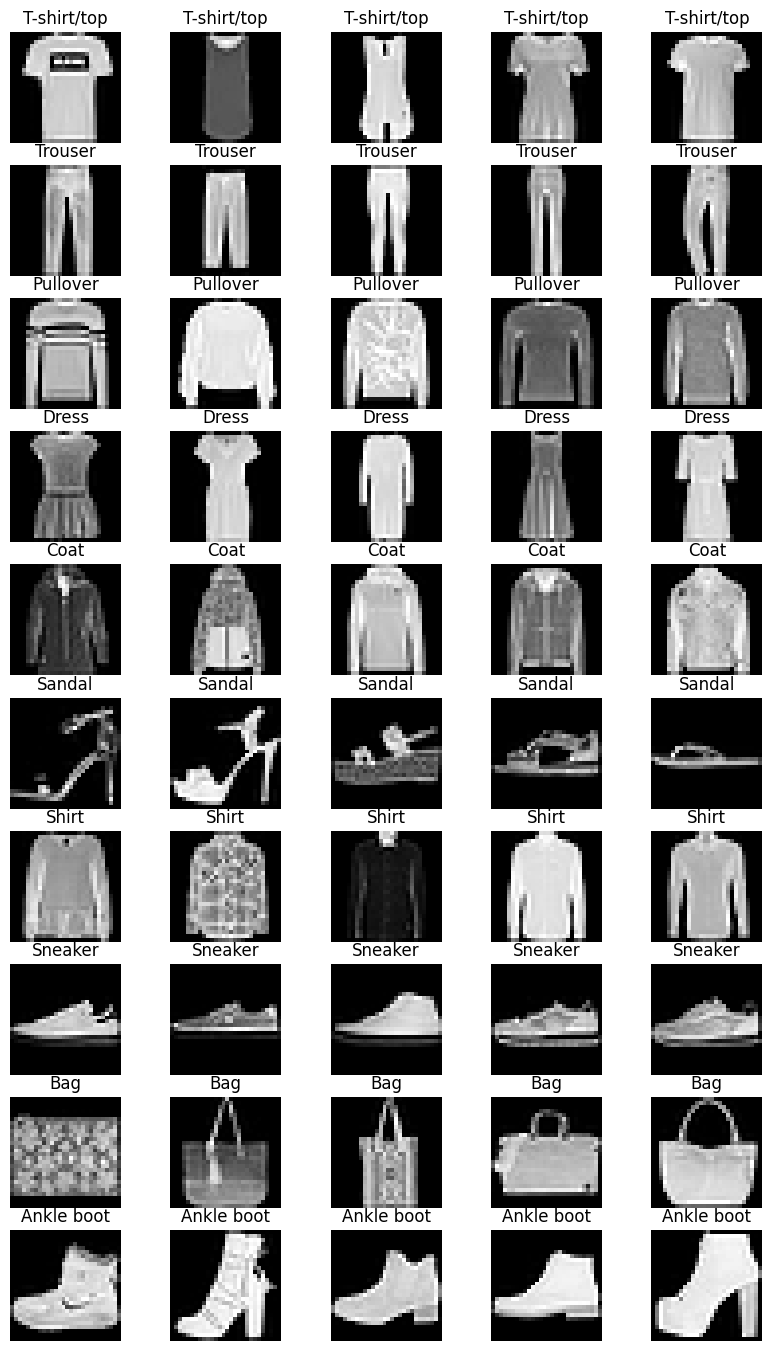

In [4]:
plt.figure(figsize=(10, 17))
num_images_per_class = 5  # Jumlah gambar per kelas
for class_id in range(10):
    # Ambil gambar pertama dari setiap kelas
    class_indices = np.where(all_labels == class_id)[0]
    for i in range(num_images_per_class):
        plt.subplot(10, num_images_per_class, class_id * num_images_per_class + i + 1)
        plt.imshow(all_images[class_indices[i]], cmap='gray')
        plt.title(class_names[class_id])
        plt.axis('off')

plt.show()

## Mengambil kelas sesuai NIM

In [ ]:
# Mengambil hanya kelas T-shirt/top dan Trouser
selected_indices = np.where((all_labels == 0) | (all_labels == 1))
filtered_images = all_images[selected_indices]
filtered_labels = all_labels[selected_indices]

## Menampilkan gambar di kelas yang sudah ditentukan

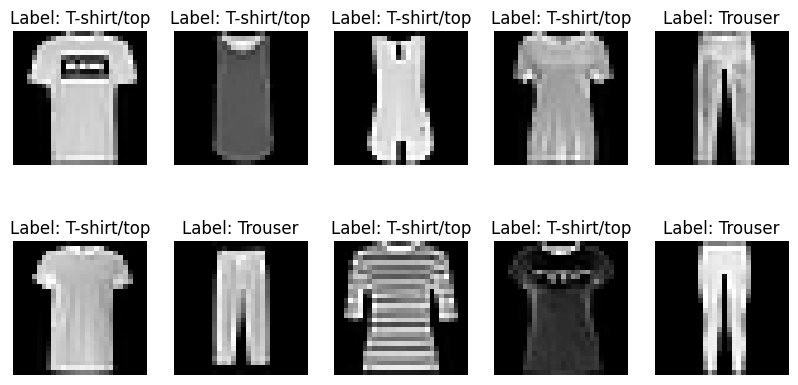

In [8]:
# Mengubah label jadi teks (0 -> T-Shirt/Top dan 1 -> Trouser)
label_names = {0: 'T-shirt/top', 1: 'Trouser'}
filtered_labels = np.vectorize(label_names.get)(filtered_labels)

# Rescaling dan konversi tipe data jadi float32
filtered_images = filtered_images.astype('float32') / 255.0
filtered_images = np.expand_dims(filtered_images, -1)

# Menampilkan contoh data yang sudah dalam label teks
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.title(f'Label: {filtered_labels[i]}')
    plt.axis('off')
plt.show()

## Split dataset ke 80% train, 10% validation, 10% test

In [9]:
train_images, temp_images, train_labels, temp_labels = train_test_split(
    filtered_images, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Menampilkan shape dari tiap splitting dataset
print(f'Train images shape: {train_images.shape}')
print(f'Validation images shape: {val_images.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

# Menampilakan size dari tiap splitting dataset
print(f"Train samples: {len(train_images)}, Validation samples: {len(val_images)}, Test samples: {len(test_images)}")


Train images shape: (11200, 28, 28, 1)
Validation images shape: (1400, 28, 28, 1)
Test images shape: (1400, 28, 28, 1)
Train labels shape: (11200,)
Validation labels shape: (1400,)
Test labels shape: (1400,)
Train samples: 11200, Validation samples: 1400, Test samples: 1400


## Membuat arsitektur autoencoder 1

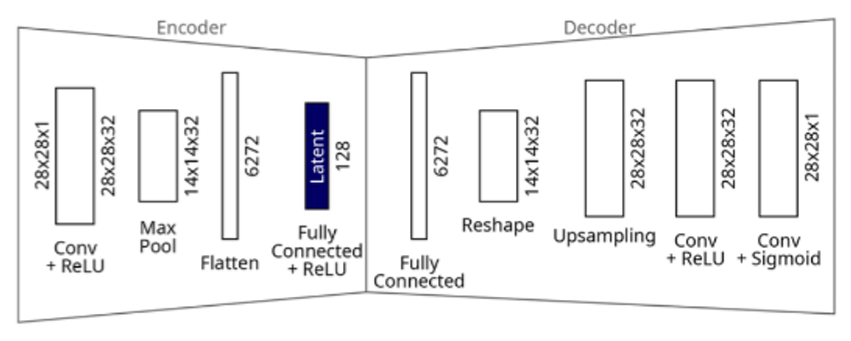

In [10]:
# Input Shape
input_shape = (28, 28, 1)
encoding_dim = 128  # Latent space dimension

# Encoder
input_img = Input(shape=input_shape, name="input_layer")
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(encoding_dim, activation='relu', name="encoding_layer")(x)

# Decoder
decoded = Dense(14 * 14 * 32, activation='relu')(encoded)
decoded = Reshape((14, 14, 32))(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(32, (3,3), activation='relu', padding='same')(decoded)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(decoded)

# Create autoencoder model
autoencoder = Model(input_img, decoded, name="Autoencoder_Model")
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Model summary
autoencoder.summary()


Model: "Autoencoder_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoding_layer (Dense)               │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,621,889 (6.19 MB)

 Trainable params: 1,621,889 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

## Training autoencoder dengan epochs 50, batch size 128, dan shuffle true.

In [11]:
# Alasan epoch 50: Setelah eksperimen, saya menemukan bahwa di epoch 50 mendapatkan skor SSIM tertinggi yaitu sekitar 90%-an, di bawah itu sekitar 85% ke atas dan di atas itu tidak meningkatkan skor SSIM secara signifikan.
# Alasan batch size 128: Berdasarkan eksperimen, batch size 128 menunjukkan hasil SSIM yang lebih tinggi dibandingkan dengan ukuran batch yang lebih kecil, serta lebih stabil dibandingkan batch yang lebih besar.
# Alasan shuffle true: mencegah model menghafal urutan data dan meningkatkan kemampuan generalisasi.
history = autoencoder.fit(
    train_images, train_images,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(val_images, val_images)
)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.4243 - val_loss: 0.2868
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2819 - val_loss: 0.2666
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2619 - val_loss: 0.2584
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2550 - val_loss: 0.2541
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2525 - val_loss: 0.2514
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2513 - val_loss: 0.2500
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2488 - val_loss: 0.2485
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2479 - val_loss: 0.2478
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2474 - val_loss: 0.2464
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2454 - val_loss: 0.2459
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2446 - val_loss: 0.2450
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2446 - val_l

## Prediksi dan kalkulasi skor SSIM

In [12]:
# Prediksi reconstructed images di test set
decoded_images = autoencoder.predict(test_images)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [13]:
# Function buat calculate SSIM
def calculate_ssim(original, reconstructed):
    original = original.squeeze() 
    reconstructed = reconstructed.squeeze()
    return ssim(original, reconstructed, data_range=1.0)

# Calculate SSIM untuk test set
ssim_scores = [calculate_ssim(test_images[i], decoded_images[i]) for i in range(len(test_images))]
average_ssim = np.mean(ssim_scores)

print(f'Average SSIM on test set: {average_ssim:.4f}')


Average SSIM on test set: 0.9038


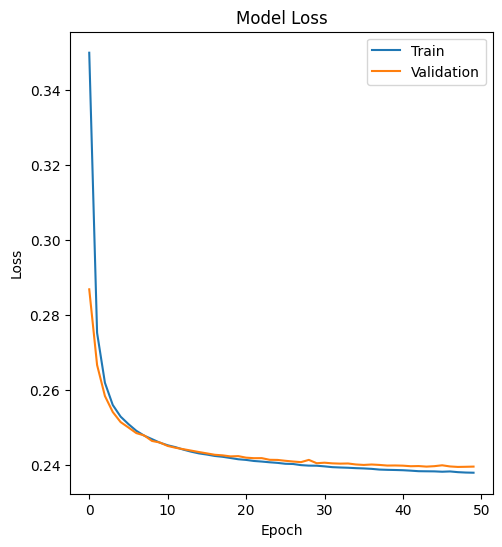

In [14]:

import matplotlib.pyplot as plt

# Plotting untuk training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

## Visualisasi perbedaan original dan reconstructed images (10 gambar)

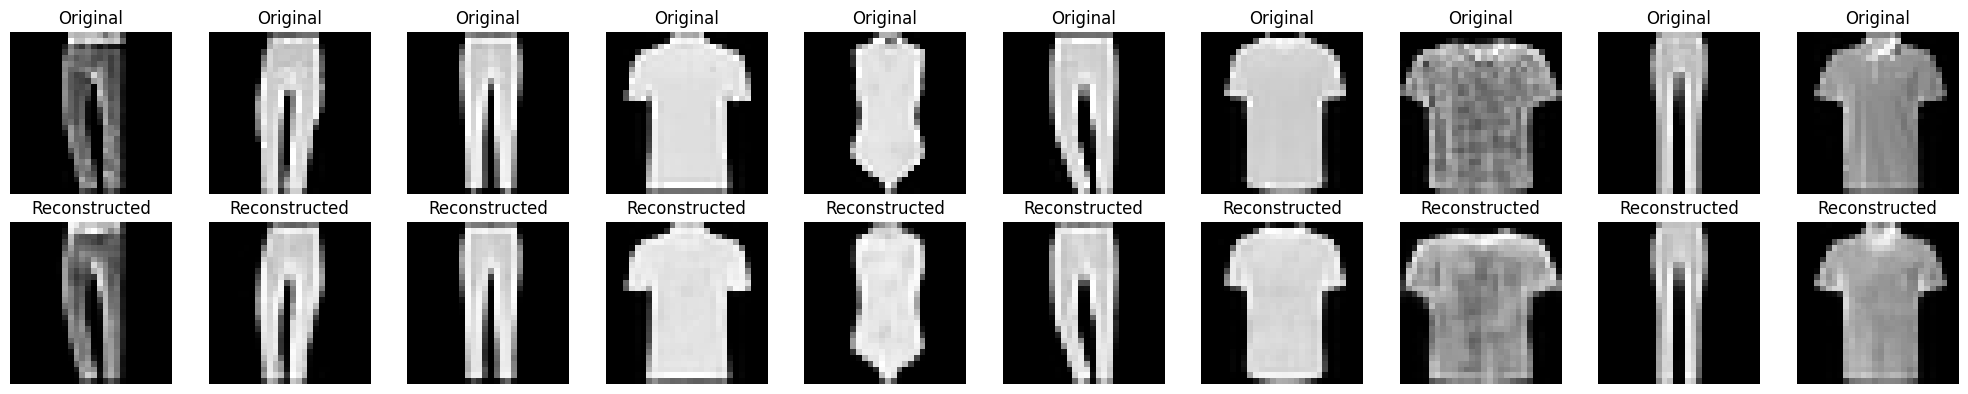

In [15]:
n = 10  
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original 
    plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed 
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


Berdasarkan hasil evaluasi saat ini:

Loss Curve Analysis:
Kurva loss menunjukkan bahwa model telah berkonvergensi dengan baik, tanpa overfitting yang signifikan.
Namun, ada indikasi bahwa performa model mungkin dapat ditingkatkan lebih lanjut dengan tuning hyperparameter.

Reconstructed Images:
Hasil rekonstruksi cukup baik, namun beberapa gambar tampak sedikit buram, yang menunjukkan bahwa model mungkin kehilangan detail penting dalam proses kompresi dan rekonstruksi.

SSIM Score:
SSIM = 0.9023, yang cukup baik, tetapi masih ada ruang untuk perbaikan.

## Modifikasi arsitektur Autoencoder

### Penjelasan

Di sini saya menggunakan kode dari Kiarash Karimi, yang memposting arsitektur Autoencodernya untuk Classification di Fashion-MNIST Dataset. 


Link Medium: https://medium.com/@akiarash10/how-to-use-autoencoders-for-classification-on-the-fashion-mnist-dataset-9ed2fcb5a272

Empat alasan mengapa saya rasa arsitektur ini bisa menghasilkan skor SSIM yang lebih baik dari arsitektur original adalah:

1. Lebih dalam dan kompleks, konvolusi bertingkat dengan jumlah filter meningkat dari 32 hingga 256. Model bisa menangkap fitur yang lebih kompleks, mulai dari fitur sederhana hingga fitur yang lebih abstrak
2. Batch normalization diterapkan setiap laposan convolution, dan batch norm membantu mengurangi overfitting dengan menambahkan sedikit noise selama training, mempercepat convergence, dan model bisa belajar lebih baik dan 3. menghindari dead neurons di network/jaringan
3. Pada encoder terdapat MaxPooling2D untuk mengecilkan dimensi gambar/downsampling sambil mempertahankan features-features penting. Lalu, di decoder UpSampling2D digunaakn untuk membangun kembali gambar dan mempertahankan details
4. Arsitektur ini dirancang dengan kapasitas model lebih tinggi sehingga generalisasi bisa lebih baik pada berbagai variasi data input

In [47]:
# Encoder
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    return conv4

# Decoder
def decoder(conv4):
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2, 2))(conv6)

    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2, 2))(conv7)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

    return decoded

# 
input_img = Input(shape=(28, 28, 1))
encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder_2 = Model(input_img, decoded, name="Autoencoder_Model_2")
autoencoder_2.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_2.summary()


Model: "Autoencoder_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 7, 7, 256)           │         590,0

 Total params: 1,758,657 (6.71 MB)

 Trainable params: 1,755,841 (6.70 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Training model autoencoder yang sudah dimodifikasi

In [48]:

# Training modified architecture autoencoder
history_2 = autoencoder_2.fit(
    train_images, train_images,
    epochs=50, 
    batch_size=128,  
    shuffle=True,
    validation_data=(val_images, val_images)
)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.4597 - val_loss: 0.5262
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2812 - val_loss: 0.4829
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2577 - val_loss: 0.4456
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2536 - val_loss: 0.3645
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2508 - val_loss: 0.2908
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2494 - val_loss: 0.2646
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2468 - val_loss: 0.2513
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2462 - val_loss: 0.2498
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2448 - val_loss: 0.2500
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2452 - val_loss: 0.2483
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2458 - val_loss: 0.2554
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.

## Prediksi model autoencoder kedua dan kalkulasi skor SSIM

In [49]:
# Prediksi reconstructed images di test set
decoded_images_2 = autoencoder_2.predict(test_images)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


In [50]:
# Calculate SSIM untuk test set
ssim_scores_2 = []
for i in range(len(test_images)):
    score_2 = ssim(
        test_images[i].squeeze(), 
        decoded_images_2[i].squeeze(), 
        data_range=decoded_images_2[i].max() - decoded_images_2[i].min()
    )
    ssim_scores_2.append(score_2)

average_ssim_2 = np.mean(ssim_scores_2)
print(f'Average SSIM after further tuning: {average_ssim_2:.4f}')


Average SSIM after further tuning: 0.9161


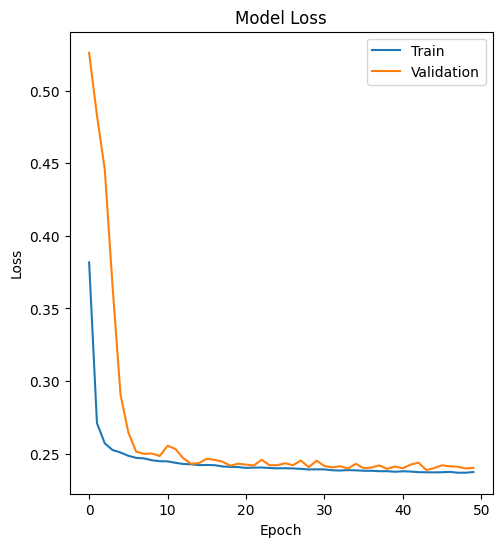

In [51]:

import matplotlib.pyplot as plt

# Plotting untuk training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

## Visualisasi perbedaan original dan reconstructed images (10 gambar)

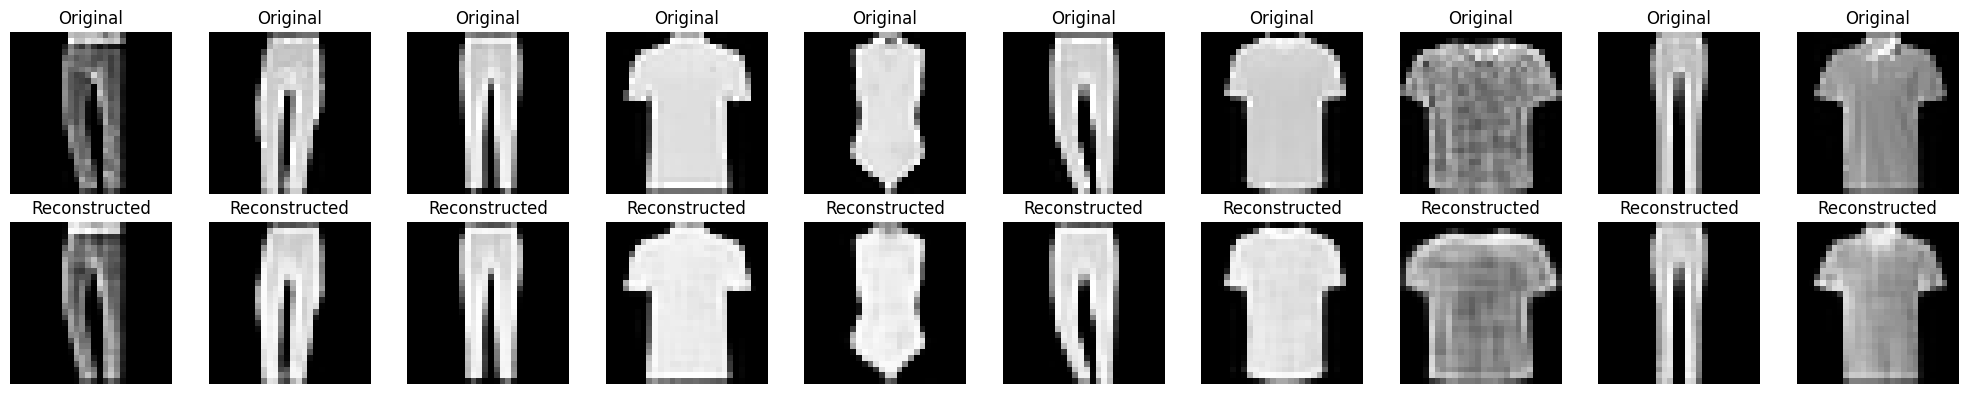

In [52]:
n = 10  

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images_2[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Mencari hyperparameter tuning terbaik menggunakan keras tuner

In [56]:
def build_autoencoder(hp):
    input_img = Input(shape=(28, 28, 1))

    # Hyperparameter tuning
    filters = hp.Choice('filters', values=[32, 64, 128])
    kernel_size = hp.Choice('kernel_size', values=[3, 5])
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    activation = hp.Choice('activation', ['relu', 'leaky_relu'])
    
    # Encoder
    conv1 = Conv2D(filters, (kernel_size, kernel_size), activation=activation, padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters * 2, (kernel_size, kernel_size), activation=activation, padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = Conv2D(filters * 2, (kernel_size, kernel_size), activation=activation, padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    up1 = UpSampling2D((2, 2))(conv3)

    conv4 = Conv2D(filters, (kernel_size, kernel_size), activation=activation, padding='same')(up1)
    conv4 = BatchNormalization()(conv4)
    up2 = UpSampling2D((2, 2))(conv4)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

    autoencoder = Model(input_img, decoded)
    
    # Compile model with hyperparameter choice
    autoencoder.compile(optimizer=optimizer_choice, loss='binary_crossentropy')
    
    return autoencoder


In [55]:
tuner = kt.RandomSearch(
    build_autoencoder,
    objective='val_loss',  # Meminimalkan validation loss
    max_trials=10,  # Jumlah kombinasi hyperparameter yang akan diuji
    executions_per_trial=1,  # Eksekusi tiap kombinasi
    directory='tuning_results',  # Direktori untuk menyimpan hasil
    project_name='autoencoder_tuning'  # Nama proAyek tuning
)

# Melakukan pencarian hyperparameter
tuner.search(train_images, train_images, epochs=20, validation_split=0.2, batch_size=32)

# Menampilkan hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best filters: {best_hps.get('filters')}")
print(f"Best kernel size: {best_hps.get('kernel_size')}")
print(f"Best activation: {best_hps.get('activation')}")
print(f"Best optimizer: {best_hps.get('optimizer')}")


Trial 10 Complete [00h 00m 28s]
val_loss: 0.2336411327123642

Best val_loss So Far: 0.23304298520088196
Total elapsed time: 00h 05m 31s
Best filters: 64
Best kernel size: 3
Best activation: relu
Best optimizer: adam


## Membangun dan melatih model berdasarkan best hyperparameter dari keras tuner

In [58]:
# Build model dengan hyperparameter terbaik
best_model = tuner.hypermodel.build(best_hps)

# Train ulang model dengan hyperparameter terbaik
history_3 = best_model.fit(
    train_images, train_images,
    epochs=50, 
    batch_size=128,  
    shuffle=True,
    validation_data=(val_images, val_images),
)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.4627 - val_loss: 0.5558
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2718 - val_loss: 0.5131
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2515 - val_loss: 0.4652
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2461 - val_loss: 0.4131
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2428 - val_loss: 0.3386
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2417 - val_loss: 0.2842
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2400 - val_loss: 0.2599
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2401 - val_loss: 0.2417
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2384 - val_loss: 0.2398
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2393 - val_loss: 0.2388
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2391 - val_loss: 0.2381
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2392 - val_l

## Menghitung skor SSIM berdasarkan hyperparameter terbaik menurut keras tuner

In [59]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

decoded_images = best_model.predict(test_images)

def calculate_ssim(original, reconstructed):
    original = original.squeeze()  
    reconstructed = reconstructed.squeeze()
    return ssim(original, reconstructed, data_range=1.0)

ssim_scores = [calculate_ssim(test_images[i], decoded_images[i]) for i in range(len(test_images))]
average_ssim = np.mean(ssim_scores)

print(f'Best model SSIM on test set: {average_ssim:.4f}')


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Best model SSIM on test set: 0.9544


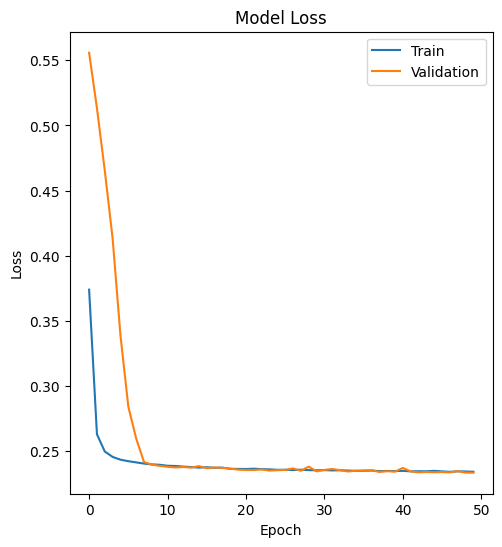

In [63]:

import matplotlib.pyplot as plt

# Plotting untuk training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

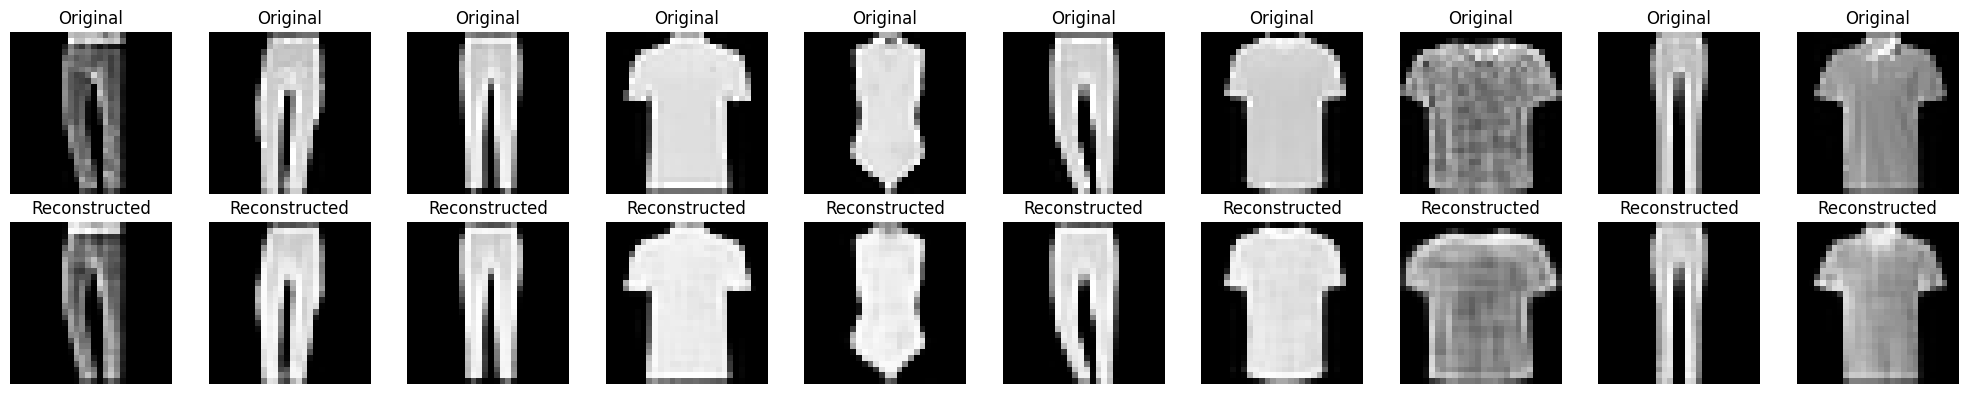

In [64]:
n = 10  

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images_2[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Kesimpulan

Model 1 (Baseline) memiliki stabilitas terbaik, tetapi skor SSIM-nya lebih rendah dibandingkan model lainnya.

Model 2 menunjukkan peningkatan performa setelah modifikasi arsitektur, tetapi masih ada sedikit overfitting.

Model 3 adalah yang terbaik setelah hyperparameter tuning dengan keras tuner untuk secara otomatis bereksperimen parameter-parameter terbaik sebanyak 10 kali percobaan dan tiap percobaan 20 epochs, dengan skor SSIM tertinggi sebesar 0.9544.
